In [1]:
import tensorflow as tf;
import numpy as np;
import matplotlib.pyplot as plt;
print(tf.__version__);
import pandas as pd;

from sklearn.metrics import mean_squared_error;

2.3.0


In [ ]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [ ]:
get_available_gpus()

In [ ]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

In [ ]:
# tf.debugging.set_log_device_placement(True)

In [2]:
multi_data = pd.read_csv('../data/zri_multifamily_v2.csv');
zip_ids = multi_data["zip"].unique();

In [ ]:
MONTHS = 72;
SPLIT = 60; # 2014-2018: training, 2019: testing.
BATCH_SIZE = 4;
WINDOW_SIZE = 6;

TEST_LENGTH = MONTHS - SPLIT;

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [ ]:
def NN_model(dataset):
    tf.keras.backend.clear_session()
    # dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

    model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                          input_shape=[None]),
    #   tf.keras.layers.Conv1D(filters=16, kernel_size=3,
    #                       strides=1, padding="causal",
    #                       activation="relu",
    #                       input_shape=[None, 1]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
        #  tf.keras.layers.SimpleRNN(16, return_sequences=True),
        #  tf.keras.layers.SimpleRNN(16, return_sequences=True),
    #   tf.keras.layers.Dense(16, activation="relu"),
    #   tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 2.0)
    ])

    optimizer = tf.keras.optimizers.SGD(learning_rate=3e-4, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer="adam",
                  metrics=["mae", "mse"])
    history = model.fit(dataset, epochs=500, verbose = 0);
    return model;

In [ ]:
def NN_forecast(model, single_city_series):
    forecast = []
    results = []
    for time in range(len(single_city_series) - WINDOW_SIZE):
        forecast.append(model.predict(single_city_series[time:time + WINDOW_SIZE][np.newaxis]))

    #print(forecast)

    # forecast = forecast[SPLIT - WINDOW_SIZE:]
    results = np.array(forecast)[:, 0, 0]
    actual = single_city_series[WINDOW_SIZE:]
    time_actual = range(WINDOW_SIZE, len(single_city_series));

    pure_forecast = list(single_city_series[SPLIT - WINDOW_SIZE: SPLIT]);
    for time in range(SPLIT, len(single_city_series)):
        # print(model.predict(pure_forecast[-WINDOW_SIZE:][np.newaxis]))
        pure_forecast.append(np.array(model.predict(np.array(pure_forecast[-WINDOW_SIZE:])[np.newaxis]))[0][0][0])
    pure_forecast = np.array(pure_forecast[WINDOW_SIZE:]);

    return results, actual, pure_forecast;

In [ ]:
@tf.autograph.experimental.do_not_convert
def NN_test(ZONE):
    '''
    Input: ZONE
    Output: the RMSE of a NN model on the predicted train, partially predicted test, and complete predicted test.
    '''
    # Collection of data
    single_city_data = multi_data[multi_data["zip"] == ZONE];
    single_city_series = np.array(single_city_data["zri"]);
    
    # Standardization
    single_city_series_mean = single_city_series.mean();
    single_city_series_std = single_city_series.std();

    single_city_series = (single_city_series - single_city_series_mean)/\
    single_city_series_std;
    
    # Train test split
    single_city_train = single_city_series[:SPLIT];
    single_city_test = single_city_series[SPLIT:];
    
    # Window the training set to make input of the NN
    dataset = windowed_dataset(single_city_train, WINDOW_SIZE, BATCH_SIZE, 60);
    model = NN_model(dataset);
    
    time_train = list(range(SPLIT));
    time_test = list(range(SPLIT, len(single_city_series)));
    
    # Forecasting
    results, actual, pure_forecast = NN_forecast(model, single_city_series);
    
    # Compute MSE
    MSE_train = mean_squared_error(actual[:-TEST_LENGTH], results[:-TEST_LENGTH])**0.5 * single_city_series_std;
    MSE_test = mean_squared_error(actual[-TEST_LENGTH:], results[-TEST_LENGTH:])**0.5 * single_city_series_std;
    MSE_pure = mean_squared_error(actual[-TEST_LENGTH:], pure_forecast[-TEST_LENGTH:])**0.5 * single_city_series_std;

    return MSE_train, MSE_test, MSE_pure, pure_forecast[-TEST_LENGTH:];

In [ ]:
# ZONE = 11050;
# with tf.device('/GPU:1'):
#     %time M_train, M_test, M_pure = NN_test(11050);

In [ ]:
# import multiprocessing  
# import random
# from multiprocessing import Pool
# from NN_predict_v1 import *;

# score_dict = {"zip":[], "RMSE_train":[], "RMSE_test":[], "RMSE_pure":[], "forecast":[]};

# if __name__ == '__main__':
#     pool = Pool()
#     #with tf.device('/cpu:0'):
#     results = pool.map(NN_test, zip_ids[:3])
#     # for value, factors in zip(to_factor, results):
#     print(results)

In [ ]:
from NN_predict_v1 import *;

score_dict = {"zip":[], "RMSE_train":[], "RMSE_test":[], "RMSE_pure":[], "forecast":[]};
with tf.device('/cpu:0'):
    for ZONE in zip_ids[:260]:
        %time M_train, M_test, M_pure, forecast = NN_test(ZONE);
        print(ZONE, M_train, M_test, M_pure, forecast);

        score_dict["zip"].append(ZONE);
        score_dict["RMSE_train"].append(M_train);
        score_dict["RMSE_test"].append(M_test);
        score_dict["RMSE_pure"].append(M_pure);
        score_dict["forecast"].append(forecast);
    

In [ ]:
print(len(score_dict["RMSE_pure"]), sum(score_dict["RMSE_pure"])/len(score_dict["RMSE_pure"]));

In [ ]:
test = pd.DataFrame(score_dict)

In [ ]:
test.head(50)

In [ ]:
test.to_csv('NN_1.csv', index = False)

### The code which combines the output from threads, and some discussions


In [ ]:
NN_1_pd = pd.read_csv('./NN_1.csv', index_col = 0);

for i in range(2,6):
    temp = pd.read_csv('./NN_{}.csv'.format(i), index_col = 0);
    NN_1_pd = pd.concat([NN_1_pd, temp], axis = 0);   
#NN_1_pd.describe()

In [ ]:
NN_1_pd.to_csv('NN_1_summary.csv')

#### The average RMSE is around 67, somewhat worse than the baseline model. Now, let's take a look inside...

In [ ]:
NN_1_pd.head()

In [ ]:
NN_1_pd = pd.read_csv('./NN_1_summary.csv', index_col = 0);
NN_1_pd.describe()

In [ ]:
NN_1_pd.sort_values("RMSE_pure", ascending = False)

Wall time: 1min 2s


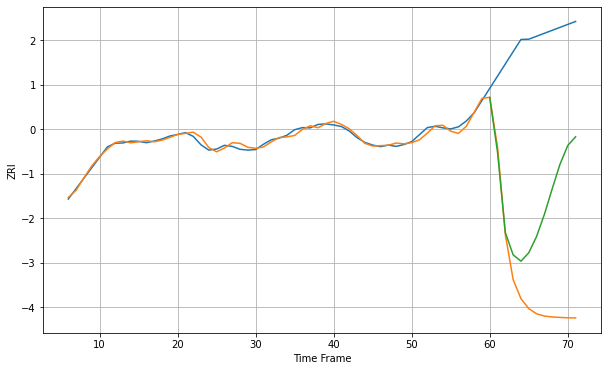

In [3]:
from NN_predict_v1 import *;

ZONE = 95928;
%time M_train, M_test, M_pure, forecast = NN_test(ZONE, plot=True);